# Tutorial 01 - Introduction to pyeCAP

Python is a python package for the analysis of evoked compound action potentials (CAPs) in elecytrophysiology data sets. This program is currently under development and all classes and methods may be subject to change.

pyeCAP was built with the goal of simplifying the collection and analysis of CAP data. As such this toolkit abstracts the technicalities of loading, saving, and working with ephys data into an efficient class structure that forms the basis for fast and interactive analysis of CAPs. This enables real-time visualization of data during an ephys recording session to allow for optimizing experimental time and resources. The pyeCAP package also contains many visualization tools for fast and interactive visualization and analysis of data after an experiment.

## Organization of pyeCAP

pyeCAP is organization into three major classes that you user will interact with. These are:
* __Ephys__ - A class for working with Ephys data. This class handles mapping ephys data sets from disk for fast analysis, preprocessing, and visualization of data. Important features include:
 - _Loading Data_
 - _Interactive Visualization and Plotting_
 - _Re-referencing strategies_
 - _Filtering_
* __Stim__ - A class for working with Stimulation data. This class handles the details of reading in stimulation data from different stimulation/recording system. Timing of stimulation pulse trains, individual pulses, and stimulation parameters can be easily worked with through the Stim class.
* __ECAP__ - The ECAP class works with Ephys and Stim data and provides an interface for analysis and visualization of ECAP data. 

## Supported Data Types

pyeCAP currently supports analysis of data collected with systems developed by Tucker Davis Technologies (https://www.tdt.com/), ADInstruments (https://www.adinstruments.com/), and Ripple Neuro (https://rippleneuro.com/) [Coming Soon].

## Enabling Interactive Data Analysis

In order to enable interactive data analysis and both real-time data as well as those stored on your computers hard disk, pyeCAP is built on the concept of lazy execution. Electrophysiology analysis scripts written by scientists are often time consuming and memory intensive to run. This is because we are often working with large data sets and in order to preprocess our data we usually read the entire data set into memory and often create copies of the data after various filtering, referencing, artifact rejection, or other procedures. Additionally, although we normally preprocess an entire data set we often only work with and plot small portions of our data at a time. 

pyeCAP is built from the ground up to work differently. Data is mapped to it's location on your hard disk, without ever reading the data into memory. A data analysis pipeline, wich can consist of various preprocessing or data analysis techniques is then built by the user. At this point zero computation has been performed. 

To interact with your data, at some point you will want to reduce processed data into some kind of summary statistics or visualization. At this point pyeCAP evaluates your data analysis procedure and determines with data needs to be accessed to return the request result. In this way it only reads from disk and analyzes the section of data that are relevant to the reduced data set on which you are performing statistics or creating visualizations from.

Chunking data in this way allows for minimizes unnecessary computations, but also allows us to easily parallelize computations across multiple chunks of data in order to take advantage of parallel processing and further accelerate your data analysis. Lastly, because chunks of data are not all stored in memory at once. pyeCAP allows you to work with large data sets on even modest computer hardware and even work on data sets that are larger than your available memory. 

For those interested. pyeCAP mainly takes advantage of a python project called Dask to parallelize operations on chunked data sets. More information on Dask and lazy evaluation can be found here: https://docs.dask.org/en/latest/


## Reading in a Data Set

Let's get started by reading in and plotting a data set with pyECAP

In [1]:
# Import the necessary libraries
import pyeCAP

In [2]:
# Importing necessary libraries
import hashlib # hashlib for generating hashes of files
import os # os for interacting with the operating system
import requests # requests for making HTTP requests
import zipfile # zipfile for extracting zip files
from tqdm import tqdm # tqdm for progress bars

# URLs of the data files to be downloaded
urls = [
    'https://gin.g-node.org/Jtrevathan/pyeCAP/raw/master/data/pnpig191126-191204-174838.zip',
    'https://gin.g-node.org/Jtrevathan/pyeCAP/raw/master/data/pnpig191126-191204-175046.zip'
]

# Expected hashes for the files
# These are used to verify the integrity of the downloaded files
expected_hashes = {
    'pnpig191126-191204-174838': '2c3e6c022dae968bc35d4e01c595c004',
    'pnpig191126-191204-175046': '6d638c7fcf00ee9fff3d39d9cb5e39b3'
}

# Function to calculate the hash of a folder
# This is used to verify the integrity of the downloaded files
def calculate_folder_hash(folder_path, hash_type="md5"):
    # Create a new hash object
    hash_obj = hashlib.md5()

    # Walk through each file in the folder
    for dirpath, dirnames, filenames in os.walk(folder_path):
        for filename in filenames:
            # Get the full path of the file
            file_path = os.path.join(dirpath, filename)

            # Update the hash object with the file's content
            with open(file_path, "rb") as f:
                for chunk in iter(lambda: f.read(4096), b""):
                    hash_obj.update(chunk)

    # Return the hexadecimal representation of the hash
    return hash_obj.hexdigest()

# Loop through each URL to download the data
for url in urls:
    # Extract the file name and folder name from the URL
    file_name = url.split("/")[-1]
    folder_name = file_name.split(".")[0]

    # Download if the folder does not exist or the hash is wrong
    if not (os.path.exists(folder_name) and calculate_folder_hash(folder_name) == expected_hashes[folder_name]):
        # Download the file
        response = requests.get(url, stream=True)
        total_size_in_bytes = int(response.headers.get('content-length', 0))
        block_size = 1024  # 1 Kibibyte
        # Create a progress bar for the download
        progress_bar = tqdm(total=total_size_in_bytes, unit='iB', unit_scale=True)
        # Write the content of the response to a file
        with open(file_name, "wb") as f:
            for block in response.iter_content(block_size):
                progress_bar.update(len(block))
                f.write(block)
        progress_bar.close()
        # Raise an exception if the download was not successful
        if total_size_in_bytes != 0 and progress_bar.n != total_size_in_bytes:
            raise Exception("File download failed.")

        print("File Downloaded! - Unzipping.")

        # Unzip the file and delete the zip file
        with zipfile.ZipFile(file_name, 'r') as z:
            z.extractall('./')
        os.remove(file_name)
        print("Files Unzipped Successfully!")
    else:
        print("Files Already Downloaded")



Files Already Downloaded
Files Already Downloaded


We will import a data set collected with a Tucker Davis Technologies (TDT) recording system. This is called a TDT tank and is stored as a directory containing a set of related files. 

Note that importing the data set is near instantaneous. This is because instantiating an instance of the Ephys class merely creates a mapping to the data stored on your hard disk and does not actually read the data into memory.

In [3]:
# path to directory containing the TDT tank
directory = r"pnpig191126-191204-174838"

# Create an instance of the Ephys class, which maps the data stored on the hard disk
# Note that this does not actually read the data into memory
data = pyeCAP.Ephys(directory)

Next we can create a simple plot of the first 5 seconds of data on all of the channels in this data set.

Once again plotting of the data should be quite fast since, since only the data necesary to make the requested plot will be accessed.

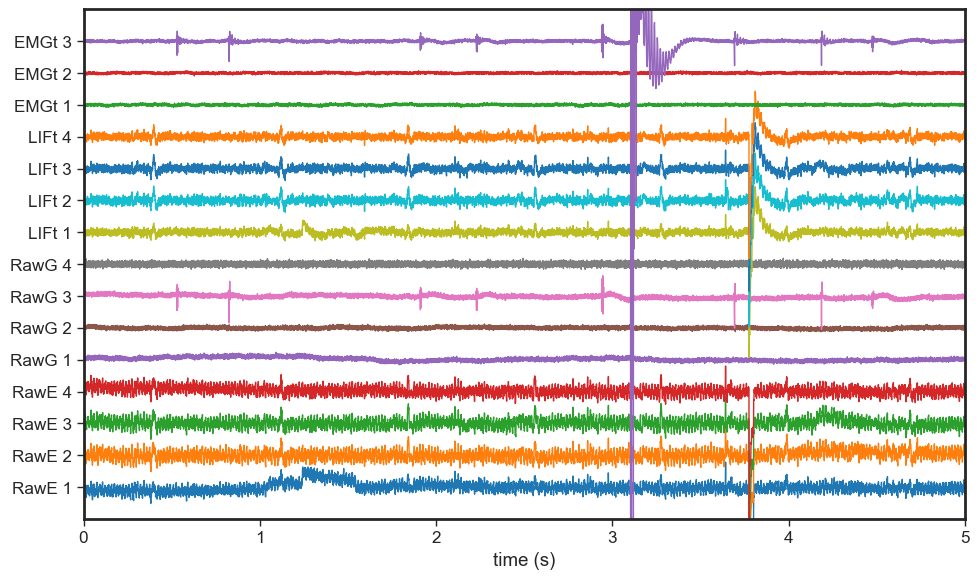

In [4]:
# Plot the first 5 seconds of data on all channels
# Only the data necessary to make the plot will be accessed
data.plot(x_lim=(0, 5))